# Coursework



Candidate number: 22817
Date submitted: 13/12/2019

### Abstract: 

Here, give an overview of your work, make sure to describe the science background, methods, results as well as comparisons to literature data. Keep short, not to exceed 250 words.

In [1]:
#Necessary imports
from astropy.io import fits #used to open fits files in which data are stored
import pylab #plotting
import glob
import numpy as np
from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.signal import medfilt
import matplotlib as plt
from photutils import aperture_photometry
import photutils
mykepler = '1' #add here the source number assigned to you, '1' or '2'

### 1. Introduction:

Give an introduction to your coursework. This should be a short description of exoplanets as well as a description of background relevant to your Discussion. Include references. Finish your introduction with an overview over the paper.

Your introduction should be understandable to a student having taken Intro to astro and Planets & Exoplanets. 




Guidline word limit: 300-500 words

Introduction

An exoplanet is any planetary body that exists outside of the Solar System. Most exoplanets are detected in orbit around a host star or stars. However, exoplanets can exist outside of extrasolar systems, but detection of these exoplanets is difficult with current methods and technology [1].  Exoplanets are difficult to directly image using current telescopes because the luminosity of the host star is much greater than that of the planet. Instead indirect methods of observing the effects of the exoplanet on the star are used to confirm the presence of an exoplanet. The ‘primary transit’ and the ‘radial velocity’ are the most common methods of detecting exoplanets orbiting around a host star. The purpose of this paper is to explore how the primary transit method is used to detect an exoplanet. Using this method one can determine the period and size of the exoplanet orbiting the star [2]. When an exoplanet passes in front of a host star, the planet blocks a small percentage of the light emitted from the star. This change in flux can be detected if the planet transit is in the plane of observation. Knowing the baseline luminosity of the star one car calculate the change in flux from the depth of the Kepler light curve. The ratio of change in flux is equal to the ratio of exoplanet to star radius. 

In this paper one will attempt to model a Kepler light curve and calculate the transit depth, period and radius of the exoplanet using data taken from the Kepler space telescope.


### 2.1 Data Reduction - Photometry

$\bullet$ describe your data reduction for the GROND dataset, which you learned in the DataReduction notebook and discuss the systematic errors.

$\bullet$ Given your science question, give a description of SN and time sampling you'll need for the data, use your work in LightCurveSimu and ImageSimu

$\bullet$ include the function you wrote for aperture photometry, you can use ImageSimulator to demonstrate your knowledge. Use photutils or custom functions for aperture photometry, other software is not accepted. Describe the function and possible limitations.

So this is data reduction of the grond set

In [ ]:
# First let's zoom into a part of the image
pylab.xlim(1100,2000)
pylab.ylim(850,50)
pylab.imshow(image.red,vmin=250,vmax=500,norm=LogNorm())

#Defining the star area + finding its flux
xpos = 1533 #x-position of object in image being measured
ypos = 424  #y-position of object in image being measured
srcrad = 20 #radius over which to measure the object's flux
starsky = photutils.CircularAperture((xpos, ypos), srcrad)
star_circle = aperture_photometry(image.red, starsky)
starflux = float(star_circle['aperture_sum'])
print ('The area over which the stars flux is measured is: ' "{:.0f}".format(float(starsky.area())))
print ('The total star flux (not ajusted for background) is: ', "{:.0f}".format(starflux))


#Defining the standard star area + finding its flux
std_star_xpos=1805.3 #x-position of object in image being measured
std_star_ypos=362.6  #y-position of object in image being measured
std_starrad = 20 #radius over which to measure the object's flux
std_starsky = photutils.CircularAperture((std_star_xpos, std_star_ypos), std_starrad)
std_star_circle = aperture_photometry(image.red, std_starsky)
std_starflux = float(std_star_circle['aperture_sum'])
print ('The area over which the standard stars flux is measured is: ' "{:.0f}".format(float(std_starsky.area())))
print ('The total standard star flux (not ajusted for background) is: ', "{:.0f}".format(std_starflux))


#Defining the sky area and finding its flux 
xpos1 = 1900 #x-position of noise
ypos1 = 200  #y-position
nrad  = 100  #radius over which to calculate background noise
awaysky = photutils.CircularAperture((xpos1, ypos1), nrad)
sky_circle = aperture_photometry(image.red, awaysky)
skyflux = float(sky_circle['aperture_sum'])
print ('The area over which background noise is calculated is: ' "{:.0f}".format(float(awaysky.area())))
print ('The total background noise in this area is: ', "{:.0f}".format(skyflux))


#plotting the measuiring radii onto the image
starsky.plot(ec='white') #the star measuring circle is plotted in white
awaysky.plot(ec='red')   #the background noise measuring circle is plotted in red
std_starsky.plot(ec='blue') #the standard star measuring circle is plotted in white

#Calculating flux of just the star
#1st calculate background noise per pixel

f1 = float(sky_circle['aperture_sum'])/awaysky.area() #Skycircle flux per pixel for away sky dimensions
f2 = f1*starsky.area() #background noise per pixel multiplied by pixel area for star

#Star flux is the flux measured in starsky - (background pixel noise per area * starsky area)
print ('Background noise per pixel is:', "{:.0f}".format(f1))
starflux_adjusted = float(star_circle['aperture_sum']) - f1*starsky.area()
print ('The flux emitted by the star (noise adjusted) is: ', "{:.0f}".format(starflux_adjusted))
std_error = np.sqrt(sky_circle['aperture_sum'])/(awaysky.area()**0.5)
sigma = np.sqrt(star_circle['aperture_sum'] + std_error**2)
sigmaf = float(sigma)
print ('The uncertainty in the emitted star flux is: +/-', "{:.1g}".format(sigmaf))


#Calculating flux of just the standard star
#1st calculate background noise per pixel

std_f1 = float(sky_circle['aperture_sum'])/awaysky.area() #Skycircle flux per pixel for away sky dimensions
std_f2 = f1*std_starsky.area() #background noise per pixel multiplied by pixel area for star

#Star flux is the flux measured in starsky - (background pixel noise per area * starsky area)
std_starflux_adjusted = float(std_star_circle['aperture_sum']) - f1*std_starsky.area()
print ('The flux emitted by the standard star (noise adjusted) is: ', "{:.0f}".format(std_starflux_adjusted))
std_sigma = np.sqrt(std_star_circle['aperture_sum'] + std_error**2)
std_sigmaf = float(std_sigma)
print ('The uncertainty in the emitted standard star flux is: +/-', "{:.1g}".format(sigmaf))


#Zeropoint calculation
#Zeropoint is the magnitude that corresponds to a source with a flux of 1 cts/sec
zeropoint =  19.50 + 2.5*np.log((std_starflux_adjusted))
print ('The magnitude of the zero point is:' "{:.4g}".format(zeropoint))

#calculating the magnitude of the measured star
Mag_star = zeropoint - 2.5*np.log(starflux_adjusted)
Mag_star_err = Mag_star*np.sqrt((sigmaf/float(star_circle['aperture_sum']))**2 + (std_sigmaf/float(std_star_circle['aperture_sum'])))
print ('The magnitude of the star is: ', "{:.4g}".format(Mag_star), '+/-', "{:.2g}".format(Mag_star_err))

### 2.2 Data Reduction - Kepler Lightcurve 

$\bullet$ describe detrending of dataset. Present code used. Document code.

$\bullet$ Present full lightcurve. Include full lightcurve as data file.

### 3. Results - Modelling of Kepler lightcurve

$\bullet$ describe fitting of transit depths and present results with errors

$\bullet$ describe periodogram and identification of periodic features in lightcurves

$\bullet$ describe motivation for any additional fitting you have done

$\bullet$ include code for all modelling in attached code or inline, describe limitations and assumptions made

### 4. Discussion

$\bullet$ present comparison of your results with data, including statistical analyis and clear figures. 

$\bullet$ limit yourself in the presentation of results, focus on fewer results that are described well, rather than presenting many figures without clear context

$\bullet$ Include a short (up to 200 word) description of a follow-up observations that would address an open question in your report.


### 5. Summary

$\bullet$ summarize your results in a bullet point format. Not to exceed 300 words.

### References:

Give all references here. Use Astronomy style references, e.g.
- Miller & Jones, 2018, ApJ, 00, 000
- Smith et al. 2019, MNRAS, 00, 000
- Willow 1972, AJ, 00, 000

And cite these in the text as "Miller & Jones (2018) showed that all exoplanets are made of cheese, however, Smith et al. (2019) showed Trappist1b is made of chocolate, as previously suggested in the literature (Willow 1972)." 

# Opening 1 FITS file

Filename: Data/Object1lc/kplr1_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   ()      
  1  LIGHTCURVE    1 BinTableHDU    162   4370R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (6, 6)   int32   


XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4370 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

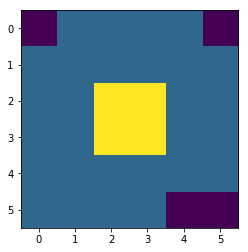

In [70]:
#Fits files are open like this:
object_1 = fits.open('Data/Object%slc/kplr%s_1.fits'%(mykepler, mykepler))
object_1.info()

#the data in the extension can be stored like this:
object_1[0].data
#the first extension is empty, it just has the information

#The last extension holds a small image of the source:
object_1[2].header
pylab.imshow(object_1[2].data)

#lets have a look at the second extension
object_1[1]
#This is a table extension

#Here the beginning has a description of columns in the table, including the units
object_1[1].header

# Plotting light curve for one FITS file

<ErrorbarContainer object of 3 artists>

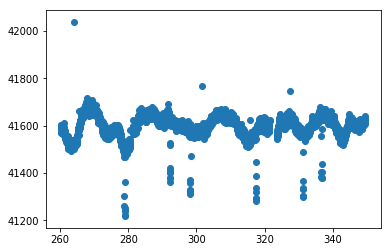

In [71]:
#Plotting the light curver as a function of time and flux:
#This plots the barycentre time and flux in e/s
#Measurements errors are also included, you can plot them as follows

pylab.errorbar(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], object_1[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='o')

#We'll need to zoom in to see the error bars


(41500, 41700)

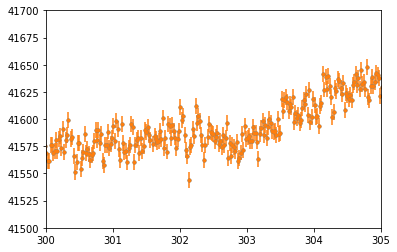

In [72]:
#Lets plot the lightcurve, you can plot the time and flux:
pylab.plot(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], ls='None', marker='.')
#This plots the barycentre time and flux in e/s

#Measurements errors are also included, you can plot them as follows
pylab.errorbar(object_1[1].data['TIME'], object_1[1].data['PDCSAP_FLUX'], object_1[1].data['PDCSAP_FLUX_ERR'], ls='None', marker='.')
#We'll need to zoom in to see them:
pylab.xlim(300, 305)
pylab.ylim(41500, 41700)

# Working with the entire data set

In [73]:
## Working with over the entire data set
glob.glob('Data/Object%slc/kplr*.fits'%(mykepler)) #Lists all your lightcurve files in the folder

['Data/Object1lc/kplr1_4.fits',
 'Data/Object1lc/kplr1_14.fits',
 'Data/Object1lc/kplr1_7.fits',
 'Data/Object1lc/kplr1_11.fits',
 'Data/Object1lc/kplr1_1.fits',
 'Data/Object1lc/kplr1_3.fits',
 'Data/Object1lc/kplr1_5.fits',
 'Data/Object1lc/kplr1_2.fits',
 'Data/Object1lc/kplr1_17.fits',
 'Data/Object1lc/kplr1_16.fits',
 'Data/Object1lc/kplr1_8.fits',
 'Data/Object1lc/kplr1_6.fits',
 'Data/Object1lc/kplr1_12.fits',
 'Data/Object1lc/kplr1_13.fits',
 'Data/Object1lc/kplr1_10.fits',
 'Data/Object1lc/kplr1_9.fits',
 'Data/Object1lc/kplr1_15.fits']

for lcfile in glob.glob('Data/Object%slc/kplr*.fits' %(mykepler)):
    tmp = fits.open(lcfile)
    tmptime = (tmp[1].data['TIME'])
    tmpflux = (tmp[1].data['PDCSAP_FLUX'])
    tmperror = (tmp[1].data['PDCSAP_FLUX_ERR'])
    pylab.plot(tmptime, tmpflux, c='k')

# Normalisation of data

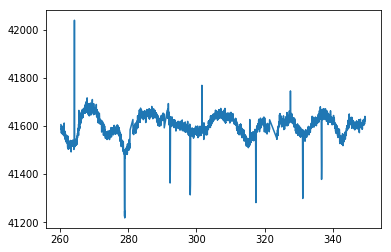

In [74]:

#
t = object_1[1].data['TIME'] #time column
f = object_1[1].data['PDCSAP_FLUX'] #point source flux data
e = object_1[1].data['PDCSAP_FLUX_ERR'] #point source flux error

#Applying a mask filter to remove nan points

nonan = ~np.isnan(f)
t = t[nonan]
f = f[nonan]
e = e[nonan]
#plot
plt.pyplot.plot(t, f)

# Savitsky-Golay

(41200, 42100)

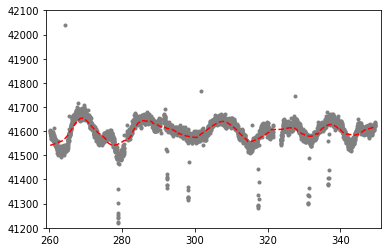

In [82]:
#Savitsky_Golay filter, fitting a polynomial to the data

#window_length is the size of the gap over which the function is interpolated 

interp_savgol = savgol_filter(f, window_length =301, polyorder=1)

#windowlength is the length of the window over which the polynomial will be fit
#polyorder is the order of the polynimial to be fit

pylab.plot(t, f, ls='None', marker='.', c='grey', label='Data')
pylab.plot(t, interp_savgol, ls='--', c='r', label='Savitzky Golay w=301,o=1')
pylab.xlim(259, 351)
pylab.ylim(41200, 42100)

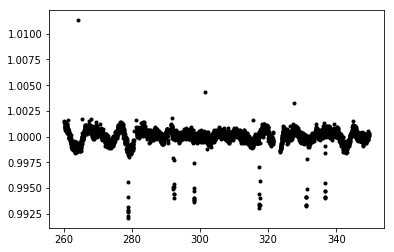

In [91]:
#plotting normalised Savitzky_Golay
pylab.plot(t, f/interp_savgol, ls='None', marker='.', c='black', label='Data normalised with Savitzky-Golay')

# Spline

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


(41200, 42100)

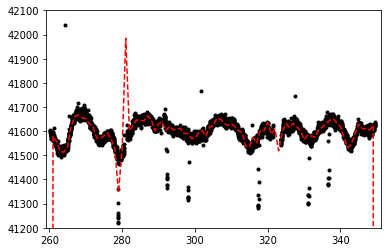

In [101]:
#Spline method
tnew = np.arange(260, 355, 1)
tnew.dtype

newfl = interpolate.spline(t, f, tnew)
pylab.plot(t, f, ls='None', marker='.', c='black', label='Data')
pylab.plot(tnew, newfl, ls='--', c='r', label='Spline')
pylab.xlim(259, 351)
pylab.ylim(41200, 42100)


In [94]:
#plotting normalised Spline
pylab.plot(t, f/newfl(t), ls='None', marker='.', c='black', label='Data normalised with Spline')

TypeError: 'numpy.ndarray' object is not callable

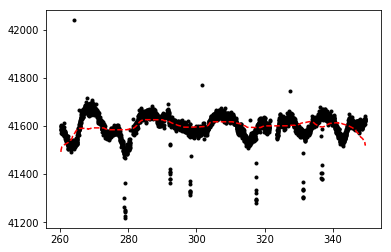

In [97]:
#kernel_size is the size of the window over which the median is calculated 

testfil = medfilt(f, kernel_size=691) 

pylab.plot(t, f, c='k', ls='None', marker='.', label='Data')
pylab.plot(t, testfil, ls='--', c='r', label='Median Filter')

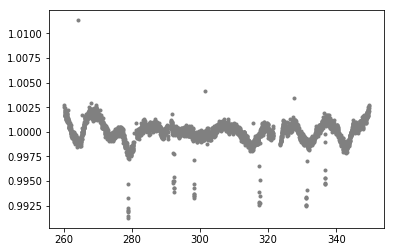

In [95]:
#plotting normalised Spline
pylab.plot(t, f/testfil, ls='None', marker='.', c='grey', label='Data')



ValueError: array must not contain infs or NaNs

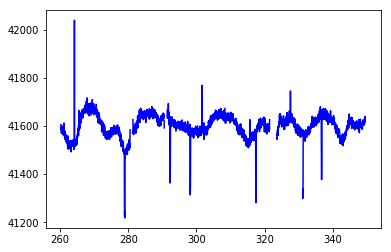

In [21]:
##FITTING MODELS

#First, define a function, the x value needs to be the first parameter to the function
#the function needs to return f(x)
def func(x, a, b, c):
    return a * numpy.exp(-b * x) + c
### Data plot
pylab.plot(t, f, 'b-', label='data')
##Now fit the data. 
popt, pcov = curve_fit(func, t, f, sigma=e)